In [43]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
#交換法

#ランダムな初期状態生成

from random import random, randrange
import numpy as np
import matplotlib.pyplot as plt
import copy

class Ising_Exchange_MC_2D:
    def __init__(self, Nx = 20, Ny = 20, n = 100, steps = 300000, average = 6):
        self.Nx = Nx
        self.Ny = Ny
        self.Ntot = Nx*Ny
        self.steps = steps
        self.average = average
        self.n = n  #レプリカ数
        self.B = 0
        self.KBT_array = np.linspace(0.5, 5, n) #温度を0.001から6までn刻みで変動させる
        self.energy_array = np.zeros((n,2*self.steps+1)) #全てのレプリカの各温度におけるエネルギーの履歴
        self.J = 1
        self.replica_list = []
        self.energy_list = []
        self.ETplot = []
        self.CTplot = np.array([])
        self.E_dispersion = []


    def each_Ecalc(self, s, Nx, Ny):
        dum = 0

        #右側のスピンとの相互作用
        for i in range(0, Nx):
            for j in range(0, Ny):

                migi = i + 1

                if migi == Nx:
                    migi = 0
                dum += s[i,j]*s[migi,j]

        #上側のスピンとの相互作用
        for i in range(0, Nx):
            for j in range(0,Ny):

                ue = j+1

                if ue == Ny:
                    ue = 0

                dum += s[i,j]*s[i,ue]

        return dum

    #スピンフリップによる状態更新
    def spin_update(self, replica_list, KBT_array, energy_list):
        for t in range(len(replica_list)):
            s = replica_list[t]
            i = randrange(self.Nx)
            j = randrange(self.Ny)

            s_trial = s.copy()   #deep copyに相当
            s_trial[i,j] = -1*s[i,j]
            if i+1 != self.Nx and j+1 != self.Ny:
                delta_E = 2*s_trial[i,j]*(-1*self.J)*(s[i+1,j]+s[i-1,j]+s[i,j+1]+s[i,j-1])-self.B*(s_trial[i,j]-s[i,j])
            elif i+1 == self.Nx and j+1 != self.Ny:
                delta_E = 2*s_trial[i,j]*(-1*self.J)*(s[0,j]+s[i-1,j]+s[i,j+1]+s[i,j-1])-self.B*(s_trial[i,j]-s[i,j])
            elif i+1 != self.Nx and j+1 == self.Ny:
                delta_E = 2*s_trial[i,j]*(-1*self.J)*(s[i+1,j]+s[i-1,j]+s[i,0]+s[i,j-1])-self.B*(s_trial[i,j]-s[i,j])
            elif i+1 == self.Nx and j+1 == self.Ny:
                delta_E = 2*s_trial[i,j]*(-1*self.J)*(s[0,j]+s[i-1,j]+s[i,0]+s[i,j-1])-self.B*(s_trial[i,j]-s[i,j])

            #メトロポリス法による状態更新
            if delta_E < 0:
                replica_list[t] = s_trial
                energy_list[t] = energy_list[t] + delta_E
            else:
                if random() < np.exp(-delta_E/KBT_array[t]):
                    replica_list[t] = s_trial
                    energy_list[t] = energy_list[t] + delta_E

        return (replica_list, energy_list)

    #レプリカ間の交換1
    def replica_exchange_even(self, replica_list, KBT_array, energy_list):
        for j in range(int(self.n/2)):
            i = 2*j
            delta_ = (KBT_array[i+1]**(-1)-KBT_array[i]**(-1))*(energy_list[i] - energy_list[i+1])

            if delta_ < 0:
                x = replica_list[i]
                replica_list[i] = replica_list[i+1]
                replica_list[i+1] = x

                y = energy_list[i]
                energy_list[i] = energy_list[i+1]
                energy_list[i+1] = y
            else:
                if random() < np.exp(-delta_):
                    x = replica_list[i]
                    replica_list[i] = replica_list[i+1]
                    replica_list[i+1] = x

                    y = energy_list[i]
                    energy_list[i] = energy_list[i+1]
                    energy_list[i+1] = y

        return  (replica_list, energy_list)

    #レプリカ間の交換2
    def replica_exchange_odd(self, replica_list, KBT_array, energy_list):
        for j in range(int(self.n/2)-1):
            i = 2*j + 1
            delta_ = (KBT_array[i+1]**(-1)-KBT_array[i]**(-1))*(energy_list[i] - energy_list[i+1])

            if delta_ < 0:
                x = replica_list[i]
                replica_list[i] = replica_list[i+1]
                replica_list[i+1] = x

                y = energy_list[i]
                energy_list[i] = energy_list[i+1]
                energy_list[i+1] = y
            else:
                if random() < np.exp(-delta_):
                    x = replica_list[i]
                    replica_list[i] = replica_list[i+1]
                    replica_list[i+1] = x

                    y = energy_list[i]
                    energy_list[i] = energy_list[i+1]
                    energy_list[i+1] = y

        return  (replica_list, energy_list)

    def Initial_rand(self, Nx, Ny):
        s = np.random.randint(0,2,(Nx,Ny))
        for i in range(Nx):
            for j in range(Ny):
                if s[i,j] == 0:
                    s[i,j] = -1
        return s

    def main(self):
        avsteps = int(self.steps * 2/self.average)

        for i in range(self.n):
            self.replica_list.append(self.Initial_rand(self.Nx, self.Ny))

        #初期エネルギー計算
        for i in range(len(self.replica_list)):
            self.energy_list.append(-self.J*self.each_Ecalc(self.replica_list[i], self.Nx, self.Ny))

        self.energy_array[:,0] = self.energy_list

        #Exchange MC
        for j in range(self.steps):
            if j == int(self.steps/3):
                print("33%")
            elif j == int(2*self.steps/3):
                print("66%")

            i = 2*j
            if j % 2 == 1:
                #まずスピンフリップ
                self.replica_list, self.energy_list = self.spin_update(self.replica_list, self.KBT_array, self.energy_list)
                self.energy_array[:,i+1] = self.energy_list

                #次に温度交換
                self.replica_list, self.energy_list = self.replica_exchange_odd(self.replica_list, self.KBT_array, self.energy_list)
                self.energy_array[:,i+2] = self.energy_list
            if j % 2 == 0:
                #まずスピンフリップ
                self.replica_list, self.energy_list = self.spin_update(self.replica_list, self.KBT_array, self.energy_list)
                self.energy_array[:,i+1] = self.energy_list

                #次に温度交換
                self.replica_list, self.energy_list = self.replica_exchange_even(self.replica_list, self.KBT_array, self.energy_list)
                self.energy_array[:,i+2] = self.energy_list

        for i in range(self.n):
            self.ETplot.append(np.sum(self.energy_array[i, -2*avsteps:])/(2*avsteps)/self.Ntot)

        plt.scatter(self.KBT_array, self.ETplot)
        plt.ylabel("Energy per spin")
        plt.xlabel("$k_{B}T$")
        plt.show()

        E2_expectation = []
        for i in range(self.n):
            E2_expectation.append(np.sum((self.energy_array[i,-2*avsteps:]/self.Ntot)**2)/(2*avsteps))
        E_expectation = np.array(self.ETplot)
        self.E_dispersion = (E2_expectation - E_expectation**2)**0.5
        self.CTplot = self.E_dispersion /(self.KBT_array**2)
        plt.scatter(self.KBT_array,self.CTplot)
        plt.ylabel("Heat capacity per spin")
        plt.xlabel("$k_{B}T$")
        plt.show()


        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.matshow(self.replica_list[0])

33%
66%


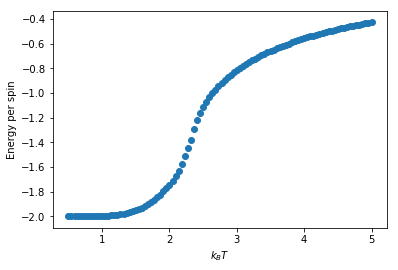

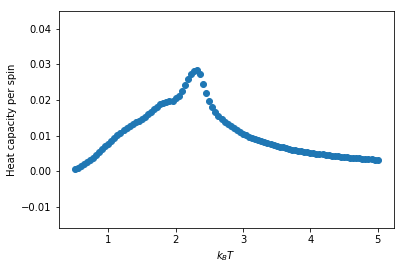

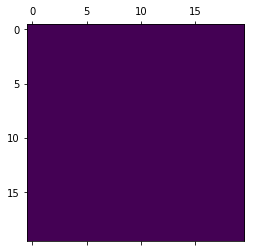

In [46]:
tmp = Ising_Exchange_MC_2D()                   #Ising2Dクラスのオブジェクトを生成
tmp.main()  

In [47]:
df= pd.read_csv('2dIsing-5.csv', header=None, delimiter = " ")

In [48]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,5.000000,-0.428562,3.635500e-04,6.091130e-03,2.479870e-05,2.628910e-05,0.000147,0.007227,5.006090e-05,7693.50,14.88010,1,4,NaN
1,4.773928,-0.451630,2.826590e-04,6.202930e-03,1.067400e-05,-3.757810e-05,0.000212,0.007690,4.538700e-05,7676.00,23.17690,1,4,NaN
2,4.567449,-0.475004,1.397530e-04,6.411470e-03,1.331650e-05,-5.198050e-04,0.000088,0.008198,3.722260e-05,7655.25,14.85700,1,4,NaN
3,4.378339,-0.499863,1.983010e-04,6.506810e-03,2.294450e-05,-2.703120e-04,0.000477,0.008927,2.953480e-05,7687.50,22.65870,1,4,NaN
4,4.205588,-0.524511,2.938500e-04,6.644720e-03,1.727840e-05,3.291800e-04,0.000250,0.009704,3.807980e-05,7690.75,16.54480,1,4,NaN
5,4.048641,-0.549020,2.392240e-04,6.821080e-03,3.449820e-05,7.116020e-04,0.000182,0.010445,3.394590e-05,7653.50,11.93380,1,4,NaN
6,3.906182,-0.574058,2.091660e-04,7.004700e-03,3.780450e-05,1.132810e-05,0.000583,0.011253,2.744330e-05,7704.75,17.08010,1,4,NaN
7,3.775208,-0.598794,1.729590e-04,7.130370e-03,2.998970e-05,4.724220e-04,0.000379,0.012267,5.553980e-05,7705.50,14.49430,1,4,NaN
8,3.653062,-0.624316,4.258970e-04,7.279650e-03,1.684110e-05,1.176950e-04,0.000181,0.013501,2.145500e-05,7672.75,15.00760,1,4,NaN
9,3.538790,-0.650489,1.530200e-04,7.540640e-03,3.119170e-05,1.444140e-04,0.000438,0.014850,2.801750e-05,7652.25,16.17800,1,4,NaN


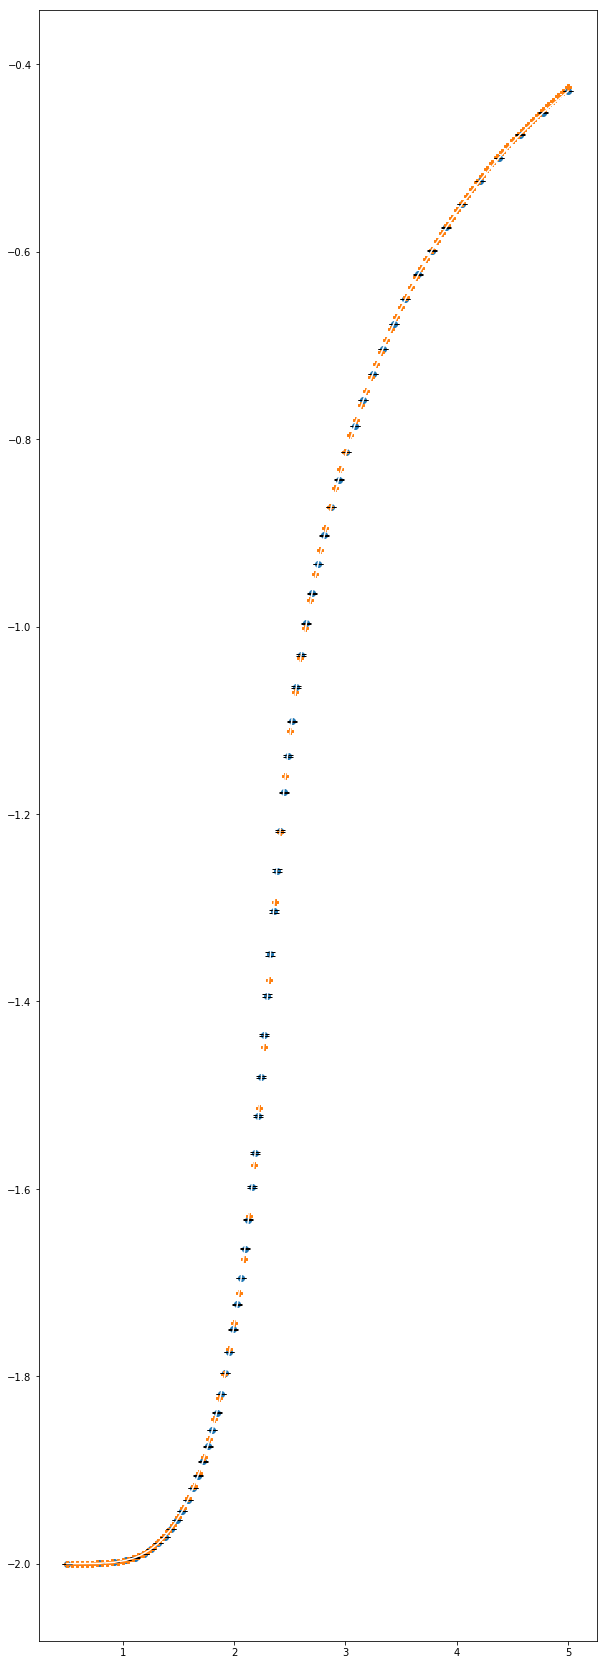

In [49]:
plt.figure(figsize=(10,30))
plt.scatter(df[0],df[1])
plt.errorbar(df[0], df[1], yerr = df[2], capsize=5, markersize=10, ecolor='black', markeredgecolor = "black", color='w')
plt.scatter(tmp.KBT_array, tmp.ETplot, marker='P')

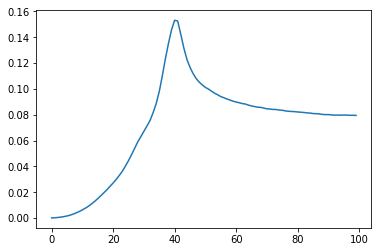

In [51]:
plt.plot(tmp.E_dispersion)